In [1]:
import numpy as np
import random

import os
import pickle
import sys
import timeit

from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.datasets import make_spd_matrix
from sklearn.ensemble import RandomForestRegressor
from scipy.stats.stats import pearsonr 

import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
from matplotlib.ticker import FormatStrFormatter

from matplotlib.pyplot import imshow
%matplotlib inline 

from IPython.display import Image 

import pickle

<img src="split_treatment.png" width="400"/>

## Generate data with no-unobs. confounding

In [ ]:
xDim = 50
nSim = 10000

A_matched_Z = []
RMSEs = []
for p_AgivenZ in [0.6, 0.7, 0.8, 0.9, 1]:
    for p_AgivenNotZ in [0.5, 0.4, 0.3, 0.2, 0.1]:

        X_data, Y_data, A_data, nObs, Group_data, Y_0_data, Y_1_data, Z, A = sim_Data(xDim, nSim, p_AgivenZ, p_AgivenNotZ)
        Yhat_0, Yhat_1 = fit_IPTW_LR(X_data, A_data, nObs)
        a_matched_z, rmse = evaluation(Yhat_0, Yhat_1, Group_data, Y_0_data, Y_1_data, A, Z)
        
        A_matched_Z.append(a_matched_z)
        RMSEs.append(rmse)

In [ ]:
A_matched_Z = np.array(A_matched_Z)
RMSEs = np.array(RMSEs)
sort_indice = np.argsort(A_matched_Z)
plt.plot(A_matched_Z[sort_indice], RMSEs[sort_indice])
plt.xlabel('% of A matched Z')
plt.ylabel('RMSE')

## Generate data violating the split-treatment criterion 

In [ ]:
xDim = 50
nSim = 10000
p_AgivenZ = 0.6
p_AgivenNotZ = 0.7

X_data, Y_data, A_data, nObs, Group_data, Y_0_data, Y_1_data, Z, A = sim_Unobs_Data(xDim, nSim, p_AgivenZ, p_AgivenNotZ)
Yhat_0, Yhat_1 = fit_IPTW_LR(X_data, A_data, nObs)
a_matched_z, rmse = evaluation(Yhat_0, Yhat_1, Group_data, Y_0_data, Y_1_data, A, Z)

## Generate data with unobs. confounding

In [ ]:
xDim = 50
nSim = 10000
p_AgivenZ = 0.9
p_AgivenNotZ = 0.1

X_data, Y_data, A_data, nObs, Group_data, Y_0_data, Y_1_data, Z, A = sim_Data(xDim, nSim, p_AgivenZ, p_AgivenNotZ)
Yhat_0, Yhat_1 = fit_IPTW_LR(X_data, A_data, nObs)
a_matched_z, rmse = evaluation(Yhat_0, Yhat_1, Group_data, Y_0_data, Y_1_data, A, Z)


In [ ]:
xDim = 50
nSim = 10000
p_AgivenZ = 0.9
p_AgivenNotZ = 0.1

X_data, Y_data, A_data, nObs, Group_data, Y_0_data, Y_1_data, Z, A = sim_Unobs_Data(xDim, nSim, p_AgivenZ, p_AgivenNotZ)
Yhat_0, Yhat_1 = fit_IPTW_LR(X_data, A_data, nObs)
a_matched_z, rmse = evaluation(Yhat_0, Yhat_1, Group_data, Y_0_data, Y_1_data, A, Z)

In [4]:
def sim_Data(xDim, nSim, p_AgivenZ, p_AgivenNotZ):
    #** Follow the graph to generate Y
    # Y = X * beta + Z * CATE

    # confounders
    x_Sigma = make_spd_matrix(xDim)
    X = np.random.multivariate_normal(np.zeros(xDim),x_Sigma,size=nSim)
    beta = np.random.choice(5, xDim, replace=True, p =[.3, .25, .2, .15, .1])

    # ground truth CATE
    CATE = np.array([1,2,3,4])
    p_G = np.exp(X[:,1])/(1+np.exp(X[:,1]))
    Group = np.zeros(nSim)
    Group[p_G < 0.75] = 1
    Group[p_G < 0.5] = 2
    Group[p_G < 0.25] = 3
    Group = Group.astype(int)

    # ground truth two-arm potential outcomes
    Y_0 = np.random.normal(np.sum(X * beta,1),1)
    #Y_1 = Y_0 + np.random.normal(CATE[Group],1)
    Y_1 = Y_0 + CATE[Group]

    # Z encourage A, and split-treatment criterion p_A_given_Z_X > p_A_given_notZ_X
    p_A_given_Z = [p_AgivenZ if x[0] > 0 else p_AgivenZ-0.1 for x in X]
    p_A_given_notZ = [p_AgivenNotZ for x in X]

#     # ground truth ITE plot
#     ite_order = np.argsort(Y_1 - Y_0)
#     plt.plot((Y_1 - Y_0)[ite_order])
#     plt.title('Ground truth ITE')

    # randomized treatment
    Z = np.random.choice(2, nSim)

    A = [np.random.choice(2, 1, p = [1-p_A_given_Z[i], p_A_given_Z[i]]) 
         if Z[i] == 1 else np.random.choice(2, 1, p = [1-p_A_given_notZ[i], p_A_given_notZ[i]])
        for i in range(nSim)]

    Y = [Y_0[i] if Z[i] == 0 else Y_1[i] for i in range(nSim)]

    Z = np.array(Z).ravel()
    A = np.array(A).ravel()
    Y = np.array(Y).ravel()
    
#     print('Z==1:',sum(Z), 'A==Z:',sum(A*Z))
    
    # return full observed data
    return X, Y, A, nSim, Group, Y_0, Y_1, Z, A

In [ ]:
def sim_Unobs_Data(xDim, nSim, p_AgivenZ, p_AgivenNotZ):
    #** Follow the graph to generate Y
    # Y = X * beta + U * gamma + Z * CATE

    #** Add a U to X, A and Y
    # confounders
    x_Sigma = make_spd_matrix(xDim)
    X = np.random.multivariate_normal(np.zeros(xDim),x_Sigma,size=nSim)
    beta = np.random.choice(5, xDim, replace=True, p =[.3, .25, .2, .15, .1])
    
    U = np.random.normal(0.5 * np.ones(nSim),1)
    gamma = 2

    # ground truth CATE
    CATE = np.array([1,2,3,4])
    p_G = np.exp(X[:,1])/(1+np.exp(X[:,1]))
    Group = np.zeros(nSim)
    Group[p_G < 0.75] = 1
    Group[p_G < 0.5] = 2
    Group[p_G < 0.25] = 3
    Group = Group.astype(int)

    # ground truth two-arm potential outcomes
    Y_0 = np.random.normal(np.sum(X * beta,1) + U * gamma,1)
    #Y_1 = Y_0 + np.random.normal(CATE[Group],1)
    Y_1 = Y_0 + CATE[Group]

    # Z encourage A, and split-treatment criterion p_A_given_Z_X > p_A_given_notZ_X
    p_A_given_Z = [p_AgivenZ if x[0]*u > 0 else p_AgivenZ-0.1 for x,u in zip(X,U)]
    p_A_given_notZ = [p_AgivenNotZ for x in X]

#     # ground truth ITE plot
#     ite_order = np.argsort(Y_1 - Y_0)
#     plt.plot((Y_1 - Y_0)[ite_order])
#     plt.title('Ground truth ITE')

    # randomized treatment
    Z = np.random.choice(2, nSim)

    A = [np.random.choice(2, 1, p = [1-p_A_given_Z[i], p_A_given_Z[i]]) 
         if Z[i] == 1 else np.random.choice(2, 1, p = [1-p_A_given_notZ[i], p_A_given_notZ[i]])
        for i in range(nSim)]

    Y = [Y_0[i] if Z[i] == 0 else Y_1[i] for i in range(nSim)]

    Z = np.array(Z).ravel()
    A = np.array(A).ravel()
    Y = np.array(Y).ravel()
    
#     print('Z==1:',sum(Z), 'A==Z:',sum(A*Z))
    
    # return full observed data
    return X, Y, A, nSim, Group, Y_0, Y_1, Z, A

In [6]:
def fit_IPTW_LR(X_data, A_data, nObs):
    # 1. Fit propensity
    clf = LogisticRegression().fit(X_data, A_data)
    propensity = clf.predict_proba(X_data)[:,1]
    p_A = np.sum(A_data)/len(A_data)
    iptw = [p_A/propensity[i] if A_data[i] == 1 else (1-p_A)/(1-propensity[i]) for i in range(nObs)]

    print('p_A: {}, IPTW: {:.2f} +/- {:.2f}'.format(p_A, np.mean(iptw), np.std(iptw)))
    
    # 2. Fit weighted LR
    X_A_data = np.array([X_data[i] * A_data[i] for i in range(nObs)])
    model = LinearRegression(fit_intercept=False).fit(np.concatenate((X_data,X_A_data, A_data.reshape(-1,1)),1),Y_data,sample_weight=iptw)
    Yhat_0 = model.predict(np.concatenate((X_data, np.zeros(X_data.shape), np.zeros((nObs,1))),1))
    Yhat_1 = model.predict(np.concatenate((X_data,X_data, np.ones((nObs,1))),1))

    return Yhat_0, Yhat_1

In [7]:
def evaluation(Yhat_0, Yhat_1, Group_data, Y_0_data, Y_1_data, A, Z):
    print('Unbiased estimated CATE: {:.2f}, {:.2f}, {:.2f}, {:.2f}'.format(
        np.mean((Yhat_1 - Yhat_0)[Group_data == 0]),
               np.mean((Yhat_1 - Yhat_0)[Group_data == 1]),
                      np.mean((Yhat_1 - Yhat_0)[Group_data == 2]),
                             np.mean((Yhat_1 - Yhat_0)[Group_data == 3])))

    est_ite_order = np.argsort(Yhat_1 - Yhat_0)
    recovered_ITE = (Y_1_data - Y_0_data)[est_ite_order]

    ite_order_data = np.argsort(Y_1_data - Y_0_data)
    ground_truth_ITE = (Y_1_data - Y_0_data)[ite_order_data]

    rmse = np.sqrt(np.mean((recovered_ITE - ground_truth_ITE)**2))
    
    A_Z_matched = sum(A == Z)/len(Z)
    print('Unbiased recovered CATE: {:.2f}, {:.2f}, {:.2f}, {:.2f}.'.format(
        np.mean(recovered_ITE[:sum(Group_data == 0)]), np.mean(recovered_ITE[sum(Group_data == 0):sum( Group_data <= 1)]),
        np.mean(recovered_ITE[sum( Group_data <= 1):sum( Group_data <= 2)]), np.mean(recovered_ITE[sum( Group_data <= 2):])))
    print('{:.1f}% A matched Z, RMSE: {:.2f}'.format(A_Z_matched * 100., rmse))
    #print('Ground truth CATE:', CATE)
    
    fig = plt.figure(figsize=(10,6))

    ax1 = fig.add_subplot(2,2,1)
    ax1.plot((Y_1_data - Y_0_data)[ite_order_data])
    ax1.set_title('Ground truth ITE')

    ax2 = fig.add_subplot(2,2,2)
    ax2.plot(recovered_ITE)
    ax2.set_title('Recovered ITE (RMSE = {:.2f})'.format(rmse))

    fig.suptitle('{:.1f}% A matched Z'.format(A_Z_matched * 100.))
    
    return A_Z_matched, rmse

In [ ]:
# # get biased observed data 
# obs_indices = [True if X[i,0] * X[i,2] > 0 else False for i in range(nSim)]

# X_data = X[obs_indices]
# A_data = A[obs_indices]
# Y_data = Y[obs_indices]

# # ground truth params
# Group_data = Group[obs_indices]
# Y_0_data = Y_0[obs_indices]
# Y_1_data = Y_1[obs_indices]

# nObs = sum(obs_indices)
# print('Num obs:', nObs)

In [ ]:
# Fit LR
model = LinearRegression(fit_intercept=False).fit(np.concatenate((X_data,X_A_data,A_data.reshape(-1,1)),1),Y_data)
Yhat_0 = model.predict(np.concatenate((X_data,np.zeros(X_data.shape),np.zeros((nObs,1))),1))
Yhat_1 = model.predict(np.concatenate((X_data,X_data,np.ones((nObs,1))),1))

print('Biased est. CATE: {:.2f}, {:.2f}, {:.2f}, {:.2f}'.format(
    np.mean((Yhat_1 - Yhat_0)[Group_data == 0]),
           np.mean((Yhat_1 - Yhat_0)[Group_data == 1]),
                  np.mean((Yhat_1 - Yhat_0)[Group_data == 2]),
                         np.mean((Yhat_1 - Yhat_0)[Group_data == 3])))

indices_sort = np.argsort(Yhat_1 - Yhat_0)
recover_CATE = (Y_1_data - Y_0_data)[indices_sort]
print('Biased rec. CATE: {:.2f}, {:.2f}, {:.2f}, {:.2f}'.format(
    np.mean(recover_CATE[:sum(Group_data == 0)]), np.mean(recover_CATE[sum(Group_data == 0):sum( Group_data <= 1)]),
    np.mean(recover_CATE[sum( Group_data <= 1):sum( Group_data <= 2)]), np.mean(recover_CATE[sum( Group_data <= 2):])))
print('Ground truth CATE:', CATE)

# Refutation Analysis

### Generating Unobserved Confounders

In [ ]:
# Treatment: A_data; Features: X_data; Labels: Y_data [ Each of shape 10k*1 or 10k*50 ]
# A and A_data are the same

xDim = 50
nSim = 10000

A_matched_Z = []
RMSEs = []
A_matched_Z_unobs = []
RMSEs_unobs = []

corr_t=[]
corr_y=[]
counter=0
for p_AgivenZ in [0.6, 0.7, 0.8, 0.9, 1]:
    for p_AgivenNotZ in [0.5, 0.4, 0.3, 0.2, 0.1]:

        X_data, Y_data, A_data, nObs, Group_data, Y_0_data, Y_1_data, Z, A = sim_Data(xDim, nSim, p_AgivenZ, p_AgivenNotZ)
        print(np.sum(Y_0_data), np.sum(Y_1_data))
        
        #Generate Obs Refutation Data
        alpha= 1000
        eps= 10*alpha
        corr_treat, corr_out, X_data_unobs= bayes_unobs_confounder(X_data, A_data, Y_data, alpha, eps)
        corr_t.append(corr_treat)
        corr_y.append(corr_out)
        
        #Results on Normal Data
        Yhat_0, Yhat_1 = fit_IPTW_LR(X_data, A_data, nObs)
        a_matched_z, rmse = evaluation(Yhat_0, Yhat_1, Group_data, Y_0_data, Y_1_data, A, Z)
        
        A_matched_Z.append(a_matched_z)
        RMSEs.append(rmse)
        
        #Results on Confounded Data
        Yhat_0, Yhat_1 = fit_IPTW_LR(X_data_unobs, A_data, nObs)
        a_matched_z, rmse = evaluation(Yhat_0, Yhat_1, Group_data, Y_0_data, Y_1_data, A, Z)
        
        A_matched_Z_unobs.append(a_matched_z)
        RMSEs_unobs.append(rmse)
        
        
#         if counter ==0:
#             counter+=1
#             print(X_data.shape, Y_data.shape, A_data.shape, Group_data.shape, Y_0_data.shape, Y_1_data.shape)
#             print(Y_data[0], Y_0_data[0], Y_1_data[0], A[0])
#             print(Y_data[10], Y_0_data[10], Y_1_data[10], A[10])
#             print(A_data)
#             print(A, Z, nObs, len(A), len(Z))
            
#             if np.array_equal(A, A_data):
#                 print('Yes')
                
#             if np.array_equal(X_data, Group_data):
#                 print('Yes')
#             else:
#                 print('No')

corr_t=np.array(corr_t)
corr_y=np.array(corr_y)

print('Final')
print('Correlation Treatment: ', np.mean(corr_t), np.std(corr_t))
print('Correlation Outcome: ', np.mean(corr_y), np.std(corr_y))

### Results with True Data

In [ ]:
A_matched_Z = np.array(A_matched_Z)
RMSEs = np.array(RMSEs)
sort_indice = np.argsort(A_matched_Z)
plt.plot(A_matched_Z[sort_indice], RMSEs[sort_indice])
plt.xlabel('% of A matched Z')
plt.ylabel('RMSE')

### Results with Unobs Confounding

In [ ]:
A_matched_Z_unobs = np.array(A_matched_Z_unobs)
RMSEs_unobs = np.array(RMSEs_unobs)
sort_indice = np.argsort(A_matched_Z_unobs)
plt.plot(A_matched_Z_unobs[sort_indice], RMSEs_unobs[sort_indice])
plt.xlabel('% of A matched Z')
plt.ylabel('RMSE')

### Sweep over Unobs Confounders

527.6918695341153 25593.691869534116
p_A: 0.5146, IPTW: 1.00 +/- 0.07
Unbiased estimated CATE: 1.31, 1.29, 1.29, 1.29
Unbiased recovered CATE: 2.55, 2.51, 2.50, 2.50.
52.7% A matched Z, RMSE: 0.98
1723.8535023824693 26520.85350238247
p_A: 0.4669, IPTW: 1.00 +/- 0.08
Unbiased estimated CATE: 1.12, 1.35, 1.55, 1.80
Unbiased recovered CATE: 1.63, 2.20, 2.77, 3.39.
56.7% A matched Z, RMSE: 0.83
829.0709838422868 25861.070983842284
p_A: 0.4251, IPTW: 1.00 +/- 0.08
Unbiased estimated CATE: 1.40, 1.59, 1.73, 1.89
Unbiased recovered CATE: 1.84, 2.29, 2.72, 3.13.
62.8% A matched Z, RMSE: 0.89
1989.3278080552832 26970.32780805528
p_A: 0.3738, IPTW: 1.00 +/- 0.07
Unbiased estimated CATE: 1.21, 1.63, 1.96, 2.38
Unbiased recovered CATE: 1.30, 2.10, 2.90, 3.69.
67.4% A matched Z, RMSE: 0.65
-506.9882797995927 24491.011720200408
p_A: 0.326, IPTW: 1.00 +/- 0.08
Unbiased estimated CATE: 1.45, 1.90, 2.33, 2.79
Unbiased recovered CATE: 1.49, 2.16, 2.84, 3.52.
73.1% A matched Z, RMSE: 0.57
2392.3846657785

/mnt/c/Users/t-dimaha/Desktop/DiCE/env/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


-129.49271675377247 24830.507283246225
p_A: 0.6747, IPTW: 1.00 +/- 0.09
Unbiased estimated CATE: 1.11, 1.54, 1.92, 2.32
Unbiased recovered CATE: 1.54, 2.19, 2.81, 3.45.
77.3% A matched Z, RMSE: 0.64


/mnt/c/Users/t-dimaha/Desktop/DiCE/env/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


-4868.495214549395 20391.504785450605
p_A: 0.6243, IPTW: 1.00 +/- 0.08
Unbiased estimated CATE: 0.98, 1.72, 2.13, 2.87
Unbiased recovered CATE: 1.16, 2.04, 2.97, 3.85.
82.4% A matched Z, RMSE: 0.55


/mnt/c/Users/t-dimaha/Desktop/DiCE/env/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


731.4079172761182 25738.40791727612
p_A: 0.5756, IPTW: 1.00 +/- 0.09
Unbiased estimated CATE: 1.13, 1.82, 2.31, 2.99
Unbiased recovered CATE: 1.16, 2.03, 2.97, 3.84.
87.4% A matched Z, RMSE: 0.50


/mnt/c/Users/t-dimaha/Desktop/DiCE/env/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


-521.7612956721384 24545.238704327865
p_A: 0.5295, IPTW: 1.00 +/- 0.09
Unbiased estimated CATE: 1.28, 2.06, 2.44, 3.21
Unbiased recovered CATE: 1.09, 2.01, 2.99, 3.90.
92.5% A matched Z, RMSE: 0.44
Item:  [0.6, 0.5, 0.5266]
Item:  [0.6, 0.4, 0.567]
Item:  [0.6, 0.3, 0.6276]
Item:  [0.6, 0.2, 0.6739]
Item:  [0.6, 0.1, 0.7311]
Item:  [0.7, 0.5, 0.5736]
Item:  [0.7, 0.4, 0.6302]
Item:  [0.7, 0.3, 0.6744]
Item:  [0.7, 0.2, 0.7228]
Item:  [0.7, 0.1, 0.7703]
Item:  [0.8, 0.5, 0.6275]
Item:  [0.8, 0.4, 0.6699]
Item:  [0.8, 0.3, 0.7274]
Item:  [0.8, 0.2, 0.7672]
Item:  [0.8, 0.1, 0.8289]
Item:  [0.9, 0.5, 0.6694]
Item:  [0.9, 0.4, 0.7255]
Item:  [0.9, 0.3, 0.7704]
Item:  [0.9, 0.2, 0.8258]
Item:  [0.9, 0.1, 0.8712]
Item:  [1, 0.5, 0.7273]
Item:  [1, 0.4, 0.7731]
Item:  [1, 0.3, 0.8237]
Item:  [1, 0.2, 0.8739]
Item:  [1, 0.1, 0.9249]


/mnt/c/Users/t-dimaha/Desktop/DiCE/env/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


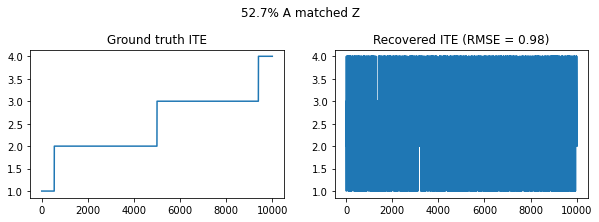

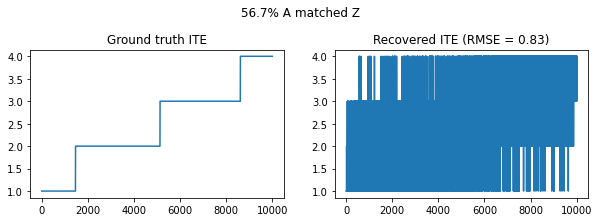

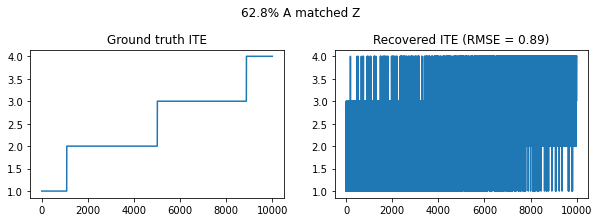

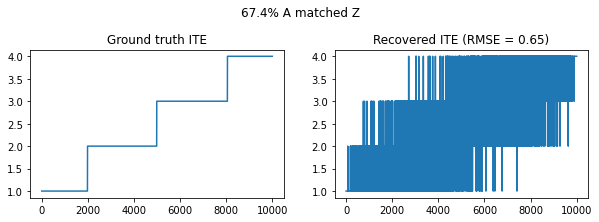

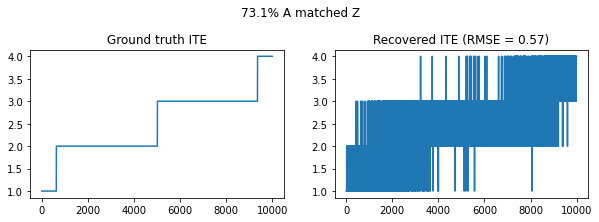

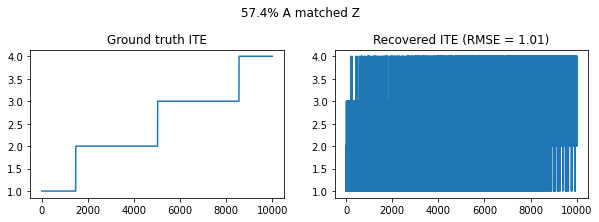

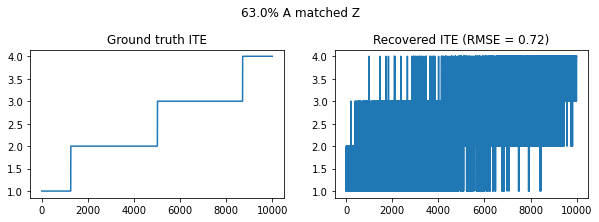

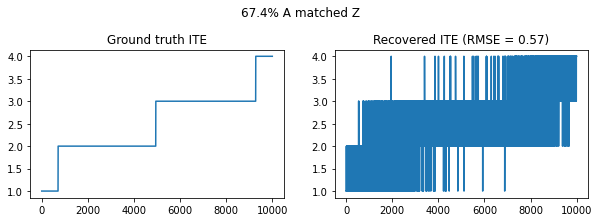

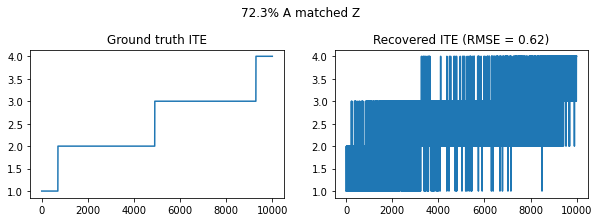

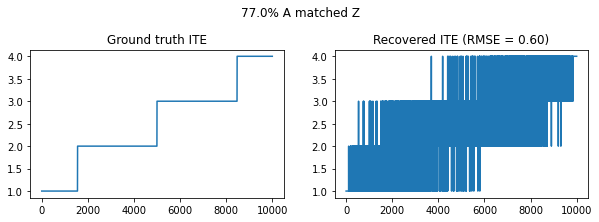

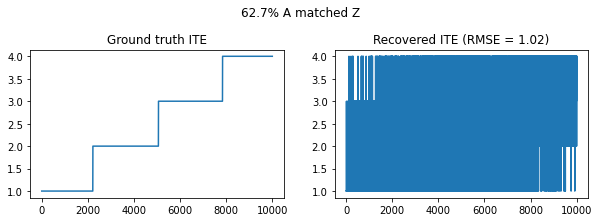

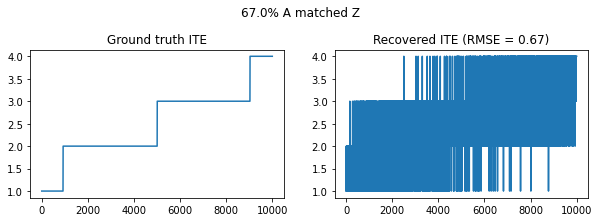

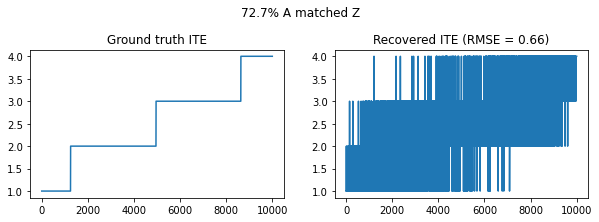

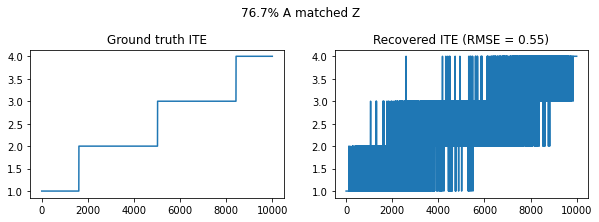

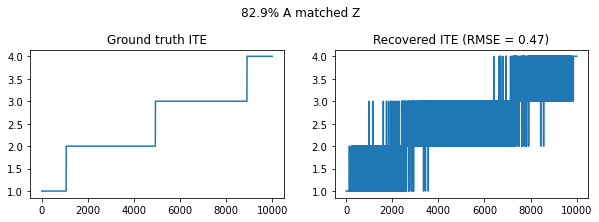

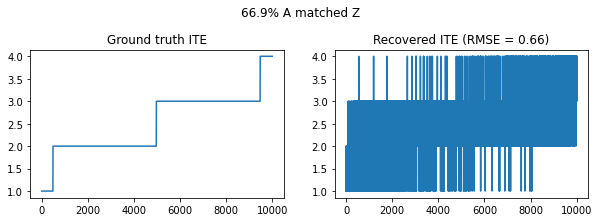

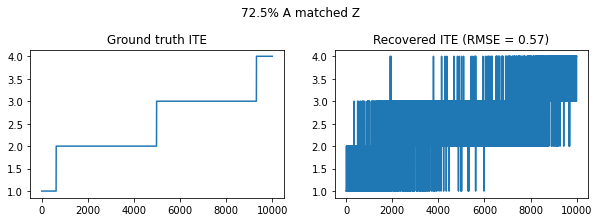

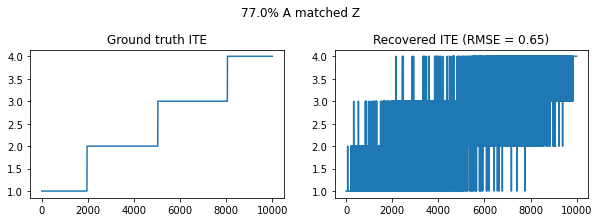

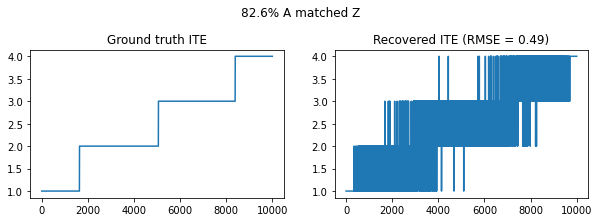

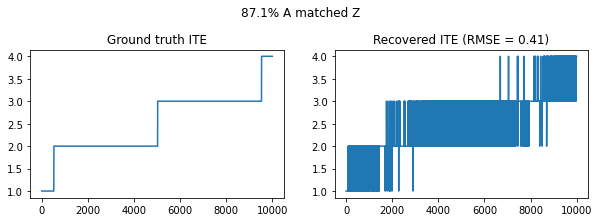

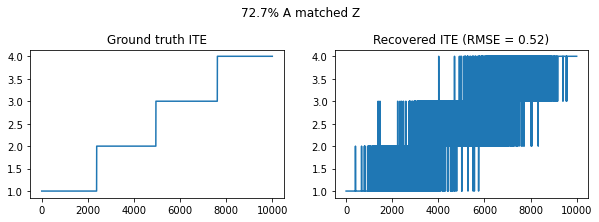

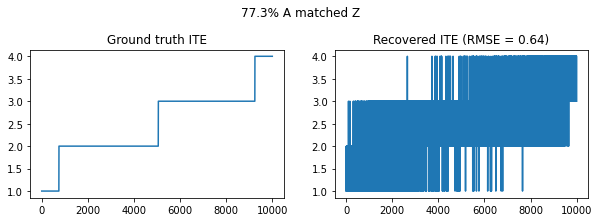

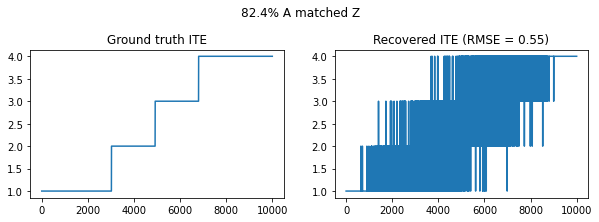

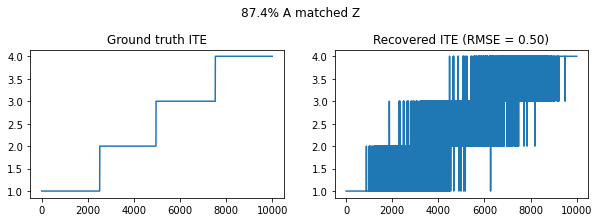

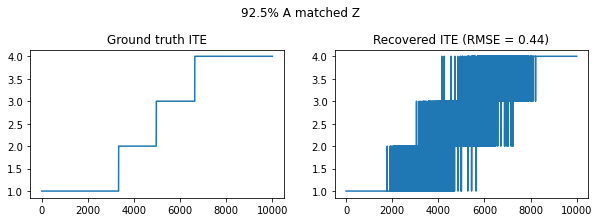

In [55]:
res=[]
for p_AgivenZ in [0.6, 0.7, 0.8, 0.9, 1]:
    for p_AgivenNotZ in [0.5, 0.4, 0.3, 0.2, 0.1]:

        X_data, Y_data, A_data, nObs, Group_data, Y_0_data, Y_1_data, Z, A = sim_Data(xDim, nSim, p_AgivenZ, p_AgivenNotZ)
        print(np.sum(Y_0_data), np.sum(Y_1_data))

        #Results on Normal Data
        Yhat_0, Yhat_1 = fit_IPTW_LR(X_data, A_data, nObs)
        a_matched_z, rmse = evaluation(Yhat_0, Yhat_1, Group_data, Y_0_data, Y_1_data, A, Z)
        
        temp=[]
        temp.append(p_AgivenZ)
        temp.append(p_AgivenNotZ)
        temp.append(a_matched_z)
        res.append(temp)
            
for item in res:
    print('Item: ', item)

-212.4244941374418 24764.57550586256
p_A: 0.5252, IPTW: 1.00 +/- 0.08
Unbiased estimated CATE: 1.22, 1.29, 1.34, 1.41
Unbiased recovered CATE: 2.27, 2.43, 2.57, 2.71.
52.4% A matched Z, RMSE: 0.97
% of A matched Z 0.5244
p_A: 0.5252, IPTW: 0.93 +/- 4.58
Unbiased estimated CATE: -0.02, 0.04, 0.06, 0.06
Unbiased recovered CATE: 2.45, 2.49, 2.51, 2.51.
52.4% A matched Z, RMSE: 1.04
Final
Correlation Treatment:  0.8054926006801435
Correlation Outcome:  0.029726387975322247
p_A: 0.5252, IPTW: 0.98 +/- 2.47
Unbiased estimated CATE: 0.14, 0.33, 0.45, 0.59
Unbiased recovered CATE: 2.29, 2.42, 2.56, 2.78.
52.4% A matched Z, RMSE: 0.97
Final
Correlation Treatment:  0.6940780491862426
Correlation Outcome:  0.025561886432416928
p_A: 0.5252, IPTW: 1.00 +/- 0.53
Unbiased estimated CATE: 0.50, 0.54, 0.60, 0.60
Unbiased recovered CATE: 2.43, 2.48, 2.51, 2.59.
52.4% A matched Z, RMSE: 1.03
Final
Correlation Treatment:  0.3929851460034288
Correlation Outcome:  0.009992174254965508
p_A: 0.5252, IPTW: 1.0

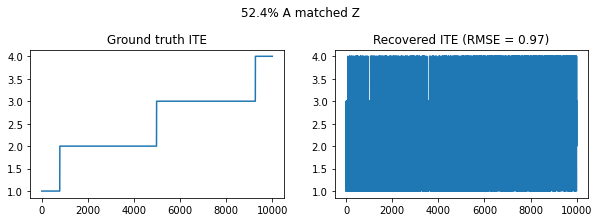

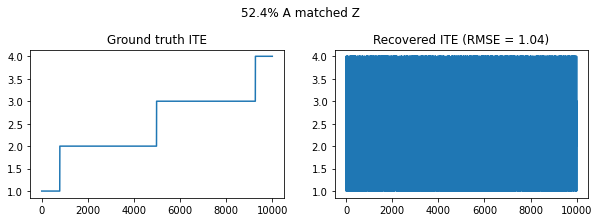

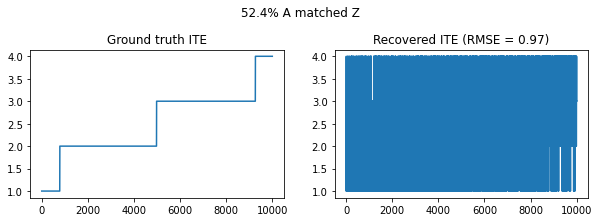

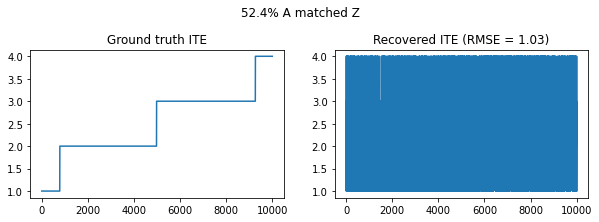

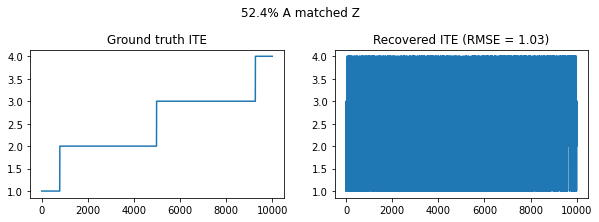

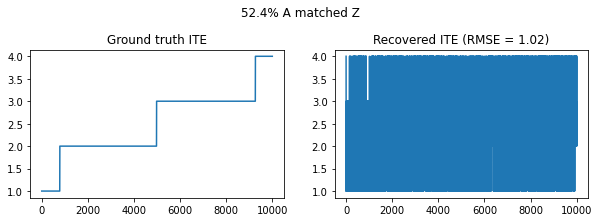

In [71]:
# Treatment: A_data; Features: X_data; Labels: Y_data [ Each of shape 10k*1 or 10k*50 ]
# A and A_data are the same

xDim = 50
nSim = 10000

#Data Generation
A_matched_Z = []
RMSEs = []

# A percentage Z match 52% params
p_AgivenZ= 0.6
p_AgivenNotZ=0.5

# A percentage Z match 77% params
# p_AgivenZ= 0.8
# p_AgivenNotZ=0.2

X_data, Y_data, A_data, nObs, Group_data, Y_0_data, Y_1_data, Z, A = sim_Data(xDim, nSim, p_AgivenZ, p_AgivenNotZ)
print(np.sum(Y_0_data), np.sum(Y_1_data))

#Results on Normal Data
Yhat_0, Yhat_1 = fit_IPTW_LR(X_data, A_data, nObs)
a_matched_z, rmse = evaluation(Yhat_0, Yhat_1, Group_data, Y_0_data, Y_1_data, A, Z)
print('% of A matched Z', a_matched_z)

A_matched_Z.append(a_matched_z)
RMSEs.append(rmse)

#UnObs Confounder
A_matched_Z_unobs = []
RMSEs_unobs = []

corr_t=[]
corr_y=[]
alpha_range= [50, 100, 500, 1000, 5000]

for alpha in alpha_range:

    #Generate Obs Refutation Data
    eps= 10*alpha
    corr_treat, corr_out, X_data_unobs= bayes_unobs_confounder(X_data, A_data, Y_data, alpha, eps)
    corr_t.append(corr_treat)
    corr_y.append(corr_out)

    #Results on Confounded Data
    Yhat_0, Yhat_1 = fit_IPTW_LR(X_data_unobs, A_data, nObs)
    a_matched_z, rmse = evaluation(Yhat_0, Yhat_1, Group_data, Y_0_data, Y_1_data, A, Z)

    A_matched_Z_unobs.append(a_matched_z)
    RMSEs_unobs.append(rmse)

    print('Final')
    print('Correlation Treatment: ', corr_treat)
    print('Correlation Outcome: ', corr_out)
    
    

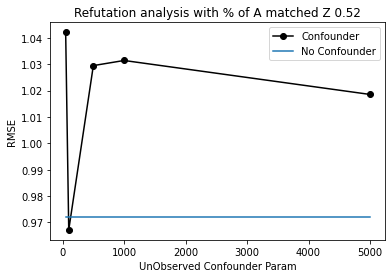

In [72]:
A_matched_Z_unobs = np.array(A_matched_Z_unobs)
RMSEs_unobs = np.array(RMSEs_unobs)
sort_indice = np.argsort(A_matched_Z_unobs)

plt.plot(alpha_range, RMSEs_unobs[sort_indice], '-ok', label='Confounder')
plt.plot(alpha_range, len(alpha_range)*RMSEs, label='No Confounder')
plt.xlabel('UnObserved Confounder Param')
plt.ylabel('RMSE')
plt.title('Refutation analysis with % of A matched Z ' + str(np.round(a_matched_z,2)))
plt.legend()
plt.savefig('images/a_52.jpg')

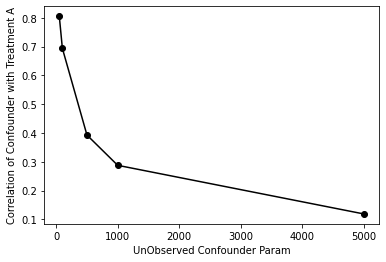

In [73]:
plt.plot(alpha_range, corr_t, '-ok')
plt.xlabel('UnObserved Confounder Param')
plt.ylabel('Correlation of Confounder with Treatment A')
plt.savefig('images/b_52.jpg')

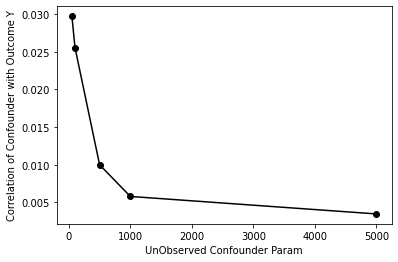

In [74]:
plt.plot(alpha_range, corr_y, '-ok')
plt.xlabel('UnObserved Confounder Param')
plt.ylabel('Correlation of Confounder with Outcome Y')
plt.savefig('images/c_52.jpg')

In [2]:
def bayes_unobs_confounder(X_data, A_data, Y_data, alpha, eps):

    treatment= A_data 
    outcome= Y_data
    total_size= X_data.shape[0]
    unobs_confounder_stats=np.zeros((2,2))

    #Compute the posterior distirbution of the unobs confounder 
    for tcase in [0,1]:
        sample_outcome= outcome[treatment==tcase]
        sample_size= sample_outcome.shape[0]

        # Posterior Mean
        unobs_confounder_stats[tcase,0]= ( alpha + tcase + sample_size*np.mean(sample_outcome))/(sample_size+1)
        # Posterior Vairance
        unobs_confounder_stats[tcase,1]= eps/(sample_size+1)
#     print('Posterior Distirbution: ', unobs_confounder_stats)

    # Sample from the unobs confounder posterior
    unobs_confounder= np.zeros((total_size))
    mu= np.zeros((total_size))
    sigma= np.zeros((total_size))
    z= np.random.normal(0,1,total_size)
    for tcase in [0,1]:
        mu[treatment==tcase]= unobs_confounder_stats[tcase,0]
        sigma[treatment==tcase]= np.sqrt( unobs_confounder_stats[tcase,1] ) 

    unobs_confounder= mu + sigma*z

    # Compute the correlation of U with T,Y
#     print( 'U Shape', unobs_confounder.shape )
#     print( 'U Val', unobs_confounder[ treatment == 0 ][:20],  unobs_confounder[ treatment == 1 ][:20] )
    corr_treat= pearsonr( unobs_confounder, treatment )
    corr_out= pearsonr( unobs_confounder, outcome )
#     print( 'Correlation Treatment: ', corr_treat )
#     print( 'Correlation_Outcome:' , corr_out )

    # Add the new column to the datatframe
    unobs_confounder= np.reshape( unobs_confounder, (unobs_confounder.shape[0], 1) )
    X_data_unobs_conf= np.concatenate((X_data, unobs_confounder), axis=1)
    
    return corr_treat[0], corr_out[0], X_data_unobs_conf

## Results

<img src='images/a_77.jpg'>
<img src='images/a_52.jpg'>

<img src='images/b_77.jpg'>
<img src='images/c_77.jpg'>